In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import scipy.interpolate as interp
import time
from tqdm import tqdm
from IPython import display
import scipy.optimize as opt
import scipy.signal as sgnl
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.special import gamma

import math

from lmfit import Minimizer, Parameters, create_params, report_fit, Model

from RW_NN import IQ_gen_NN, IQ_gen_NN_cpu

tensorflow version = 2.10.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 608116115726585360
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5360148432
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15591628986498700443
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_de (Dense)            (None, 3024)              12096     
                                                                 
 reshape_1 (Reshape)         (None, 63, 48)            0         
                                                                 
 conv1dtrs_de (Conv1DTranspo  (None, 126, 48)          11568     
 se)                                                            

## pyvista visualization

In [2]:
n_grid = 128
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)

r_grid = np.meshgrid(x,y,z) 

#### Wave vector distribution ####
def sample_k(k_mean,k_cov):
    return np.random.multivariate_normal(k_mean,k_cov)

#### Superpositioning the random wave ####
def rotation_matrix(axis, phi):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(phi / 2.0)
    b, c, d = -axis * np.sin(phi / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def sample_wave_MO(r_grid, k_mean, k_cov, n_wave = 100, kappa=1e8):
    rho = np.zeros_like(r_grid[0])
    r_grid = [r.astype(np.float32) for r in r_grid]
    for i in range(n_wave):
        phi = np.random.rand()*2*np.pi # random phase
        k_sample = sample_k(k_mean,k_cov)

        # misorientation
        """
        https://en.wikipedia.org/wiki/Von_Mises%E2%80%93Fisher_distribution
        https://doi.org/10.1080/03610919408813161
        """
        sigma = 1e-6
        xi = np.random.rand()
        theta = np.random.rand()*2*np.pi
        W = 1+1/kappa*(np.log(xi*(1-(xi-1)/xi*np.exp(-2*kappa))))
        phi = np.arccos(W)
        axis = [np.cos(theta),np.sin(theta),0]
        R = rotation_matrix(axis,phi)
        k_sample_rot = R@k_sample

        k_dot_r = np.sum([r_grid[x]*k_sample_rot[x] for x in range(3)],axis=0)
        rho_i = np.cos(k_dot_r.astype(np.float32) + phi) # cos(k_n.r + phi_n)
        rho += rho_i

    rho = np.sqrt(2/n_wave)*rho
    
    return rho

def std_phi(kappa):
    xi_list = np.linspace(1/10000,1,10000)
    W = 1+1/kappa*(np.log(xi_list*(1-(xi_list-1)/xi_list*np.exp(-2*kappa))))
    phi = np.arccos(W)
    sigma = np.sqrt(np.sum(phi**2*np.sin(phi))/np.sum(np.sin(phi)))/np.pi*180
    return sigma

In [3]:
def clip_random_wave(fp_opt, T=100):
    ### Clipping random wave ####
    k_mean = np.array([0,0,20])*np.pi
    k_var  = (np.array([0,0,fp_opt['sigma_k']])*np.pi)**2 # k_z
    k_cov  = np.diagflat(k_var)

    rho = sample_wave_MO(r_grid,k_mean/2,k_cov/2,n_wave = 60, kappa = fp_opt['kappa']) # kappa

    alpha = fp_opt['alpha'] # alpha

    ### pyvista ###
    import pyvista as pv
    pv.set_jupyter_backend('trame')
    # https://stackoverflow.com/questions/6030098
    grid = pv.StructuredGrid(r_grid[0], r_grid[1], r_grid[2])
    grid["vol"] = rho.flatten('F')
    mesh = grid.contour([alpha])

    # Visualization
    pv.set_plot_theme('document')
    pl = pv.Plotter(window_size=[600, 600])
    pl.enable_anti_aliasing('msaa')

    backface_params = dict(color='#303030',
                        ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
    #                        opacity=0.5
                        )
    pl.add_mesh(mesh, show_scalar_bar=False, color='#A0A0A0',  
                ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
                backface_params=backface_params, 
                smooth_shading=True, 
    #             opacity=0.5
                )

    # camera setting
    pl.camera_position = 'yz'
    pl.camera.azimuth = -60.0
    pl.camera.elevation = 24.0
    pl.camera.reset_clipping_range()

    # light setting
    light = pv.Light()
    light.set_direction_angle(21, -55.0)
    light.attenuation_values = (0,0,2)
    pl.add_light(light)

    path = '../Figures/'
    isExist = os.path.exists(path)
    if not isExist:
        # Create a new directory because it does not exist
        os.makedirs(path)
        print('new directory created')

    filename = path+'PSPDMS_{:0.0f}_{:0.4f}-{:0.4f}-{:0.4f}.png'.format(T,fp_opt['sigma_k'],fp_opt['kappa'],fp_opt['alpha'])
    pl.show(screenshot=filename)

## load experimental data

In [4]:
W_list = [30,40,50]
## load D22 data
data_path = '../Data/AOT/'
data_list = []
for W in W_list:
    filename = '{}.dat'.format(W)
    data = np.genfromtxt(data_path + filename, skip_header=39, delimiter='\t')
    data_list.append(data)
    # Q = data[:,0]
    # IQ = data[:,1]
    # IQ_er = data[:,2]
    # sigma_Q = data[:,3]

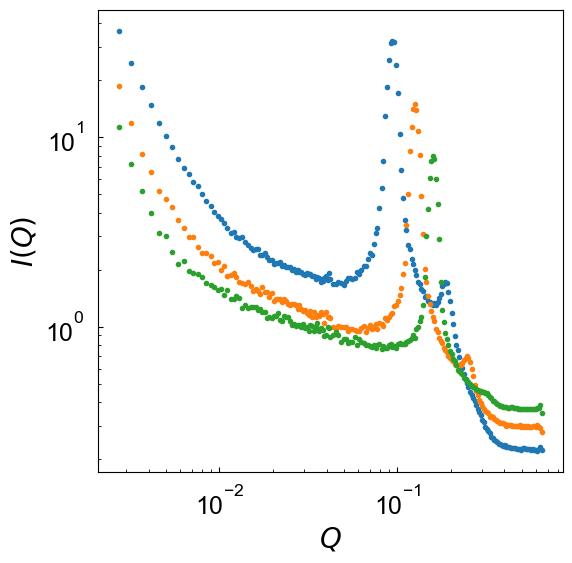

In [5]:
## plot loaded data
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
for i_W, W in enumerate(W_list):
    data = data_list[i_W]
    Q = data[:,0]
    IQ = data[:,1]
    IQ_er = data[:,2]
    sigma_Q = data[:,3]
    ax.plot(Q, IQ,'.', label=data[0])

ax.set_xlabel(r'$Q$',fontsize=20)
ax.set_ylabel(r'$I(Q)$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

max_Q = 0.64574395
0.09388037
0.12554282
0.15828075


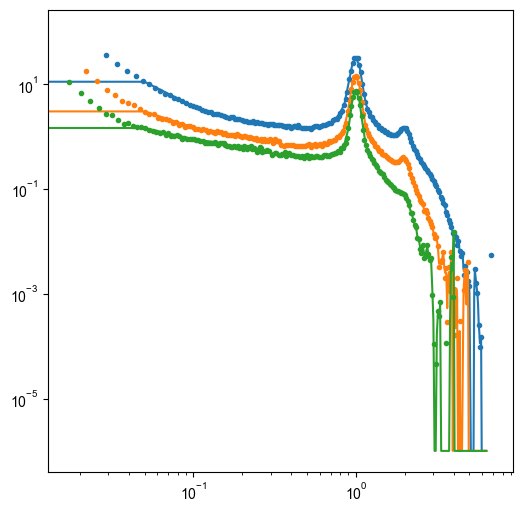

In [6]:
IQ_list = []
Q_err_list = []
Q_max_list = []
max_Q = Q[-1]
print('max_Q = {}'.format(max_Q))

box_size = 2
n_grid_scale = 256
dq = 2*np.pi/box_size
qq = np.arange(n_grid_scale/2)*dq

## plot loaded data
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
colors = ['C0','C1','C2','C3','C4']
for i_W, W in enumerate(W_list):
    data = data_list[i_W]
    Q = data[:,0]
    IQ = data[:,1]
    IQ_er = data[:,2]
    sigma_Q = data[:,3]

    # ## trim low Q
    # index_Q = Q_in>7e-3
    # Q = Q_in[index_Q]
    # IQ = IQ_in[index_Q]
    # IQ_err = IQ_err_in[index_Q]

    # ## extend low Q
    # index_low_Q = Q<3.5e-2
    # Q_low_Q = Q[index_low_Q]
    # IQ_low_Q = IQ[index_low_Q]
    # coeff = np.polyfit(Q_low_Q, IQ_low_Q, 2)
    # p = np.poly1d(coeff)
    # IQ[index_low_Q] = p(Q_low_Q)

    ## substrate background
    index_high_Q = Q>5e-1
    IQ_high_Q = IQ[index_high_Q]
    I_bg = np.median(IQ_high_Q)
    IQ = IQ - I_bg

    # ## substrate low-Q
    # A_4 = IQ[0]/Q[0]**(-4)
    # IQ_4 = A_4*Q**(-4)
    # IQ = IQ - IQ_4*0

    # ## extend high Q
    # index_high_Q = (Q>2e-1)
    # index_high_Q_fit = (Q>2e-1)*(Q<3e-1)
    # Q_high_Q = Q[index_high_Q_fit]
    # IQ_high_Q = IQ[index_high_Q_fit]
    # coeff = np.polyfit(Q_high_Q, np.log(IQ_high_Q), 2)
    # p = np.poly1d(coeff)
    # IQ[index_high_Q] = np.exp(p(Q[index_high_Q]))

    ## peak_position
    index_peak_range = Q>4e-2
    Q_peak_range = Q[index_peak_range]
    IQ_peak_range = IQ[index_peak_range]

    index_Q_max = np.argmax(IQ_peak_range)
    Q_max = Q_peak_range[index_Q_max]
    print(Q_max)
    Q_max_list.append(Q_max)
    Q_rs = Q/Q_max*np.pi*20
    f_interp = interp.interp1d(Q_rs, IQ, kind='linear',fill_value='extrapolate')
    IQ_interp = f_interp(qq)
    IQ_interp[IQ_interp<0] = 1e-6

    IQ_list.append(IQ_interp)

    # ## interpolate resolution
    # f_interp = interp.interp1d(Q_rs, Q_err_in, kind='linear',fill_value='extrapolate')
    # Q_err_interp = f_interp(qq)/Q_max*np.pi*20
    # Q_err_list.append(Q_err_interp)

    ax.plot(qq/(np.pi*20), IQ_interp, '-', label=data[0], color=colors[i_W])
    ax.plot(Q/Q_max, IQ, '.', color=colors[i_W])
    # ax.plot(qq[5:], Q_err_interp[5:], '.-', label=data[0])
    # ax.plot(Q_high_Q, IQ[index_high_Q], '.', label=data[0])
    # ax.plot(Q,IQ)

IQ_list = np.array(IQ_list)
Q_err_list = np.array(Q_err_list)

# ax.set_ylim([1e-1,1e2])

ax.set_yscale('log')
ax.set_xscale('log')

## Fit the data

In [7]:
def IQ_th(Q, params):
    v = params.valuesdict()
    fp = [v['sigma_k'],v['kappa'],v['alpha']]
    IQ_NN = IQ_gen_NN(fp)
    Q_scaled = Q*v['x_scale']
    f_interp = interp.interp1d(Q_scaled, np.log(IQ_NN), kind='cubic', fill_value='extrapolate')
    IQ_scaled = np.exp(f_interp(Q))
    return IQ_scaled*v['y_scale']

def lmbda(params, Q, data, index_Q):
    IQ_model = IQ_th(Q, params)
    residue = ((data*Q**4) - (IQ_model*Q**4))[index_Q]
    return residue

### 30%

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1271
    # data points      = 54
    # variables        = 5
    chi-square         = 3.0995e+17
    reduced chi-square = 6.3256e+15
    Akaike info crit   = 1969.45580
    Bayesian info crit = 1979.40072
##  Warning: uncertainties could not be estimated:
[[Variables]]
    sigma_k:  0.77505221 (init = 0.5)
    kappa:    5.29322569 (init = 5)
    alpha:    0.59992145 (init = 0.5)
    y_scale:  581627.369 (init = 1000000)
    x_scale:  1.02953666 (init = 1.05)


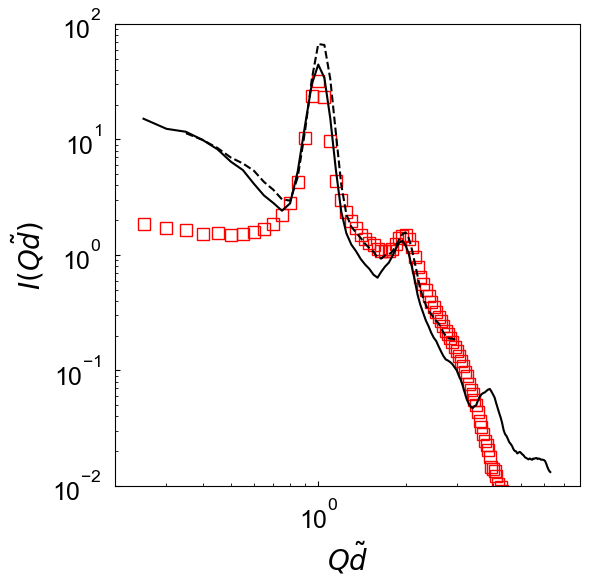

In [8]:
# fitting targets
index_data = 0
IQ_data = IQ_list[index_data,1:-1]
index_qq_fit = (qq[1:-1]/np.pi/20>0.3)*(qq[1:-1]/np.pi/20<3)

IQ_data = IQ_data
qq_data = qq[1:-1]

# create parameters for fitting
x0 =  [0.5, 5,  0.5,  1e6, 1.05]
lb =  [0.2, 4,  0.1, 5e5, 0.9]
ub =  [1.0, 10, 0.6, 2e6, 1.1]
fp_names = ['sigma_k', 'kappa', 'alpha', 'y_scale', 'x_scale']

params = Parameters()
for i_names in range(5):
    params.add(fp_names[i_names], value=x0[i_names], min=lb[i_names], max=ub[i_names])
    
index_Q = index_qq_fit

# do fit, here with the default leastsq algorithm
minner = Minimizer(lmbda, params, fcn_args=(qq_data, IQ_data, index_Q))
result = minner.minimize('nedler')

# write error report
report_fit(result)

## plot fitting results
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

index_plot = qq_data>15
ax.plot(qq_data[index_plot]/np.pi/20,IQ_data[index_plot],'sr',fillstyle='none',ms=8)
ax.plot(qq_data[index_qq_fit]/np.pi/20,IQ_th(qq_data,params)[index_qq_fit],'k--')
ax.plot(qq_data[index_plot]/np.pi/20,IQ_th(qq_data,result.params)[index_plot],'k-')

ax.set_xlabel(r'$Q\tilde{d}$',fontsize=20)
ax.set_ylabel(r'$I(Q\tilde{d})$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.2,8])
ax.set_ylim([0.01,100])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

### 40%

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 617
    # data points      = 54
    # variables        = 5
    chi-square         = 5.0288e+15
    reduced chi-square = 1.0263e+14
    Akaike info crit   = 1746.90825
    Bayesian info crit = 1756.85317
##  Warning: uncertainties could not be estimated:
[[Variables]]
    sigma_k:  0.86071089 (init = 0.8)
    kappa:    5.16484316 (init = 5)
    alpha:    0.59965545 (init = 0.4)
    y_scale:  187870.238 (init = 200000)
    x_scale:  1.02320380 (init = 1.05)


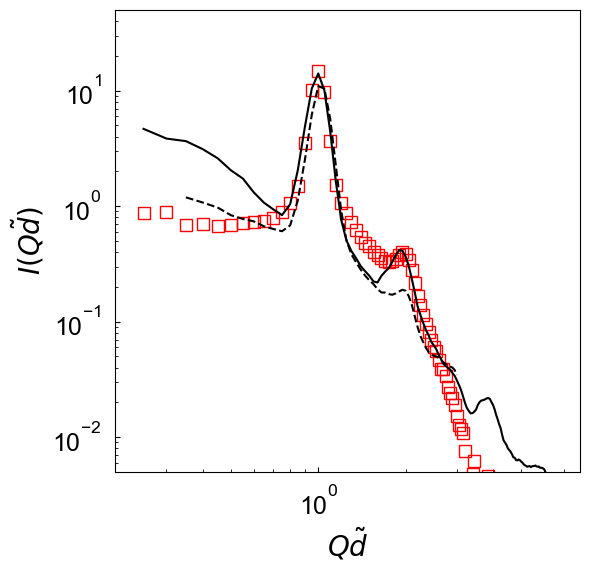

In [9]:
# fitting targets
index_data = 1
IQ_data = IQ_list[index_data,1:-1]
index_qq_fit = (qq[1:-1]/np.pi/20>0.3)*(qq[1:-1]/np.pi/20<3)

IQ_data = IQ_data
qq_data = qq[1:-1]

# create parameters for fitting
x0 =  [0.8, 5,  0.4, 2e5, 1.05]
lb =  [0.2, 4,  0.1, 5e4, 0.9]
ub =  [1.5, 10, 0.6, 1e6, 1.1]
fp_names = ['sigma_k', 'kappa', 'alpha', 'y_scale', 'x_scale']

params = Parameters()
for i_names in range(5):
    params.add(fp_names[i_names], value=x0[i_names], min=lb[i_names], max=ub[i_names])
    
index_Q = index_qq_fit

# do fit, here with the default leastsq algorithm
minner = Minimizer(lmbda, params, fcn_args=(qq_data, IQ_data, index_Q))
result = minner.minimize('nedler')

# write error report
report_fit(result)

## plot fitting results
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

index_plot = qq_data>15
ax.plot(qq_data[index_plot]/np.pi/20,IQ_data[index_plot],'sr',fillstyle='none',ms=8)
ax.plot(qq_data[index_qq_fit]/np.pi/20,IQ_th(qq_data,params)[index_qq_fit],'k--')
ax.plot(qq_data[index_plot]/np.pi/20,IQ_th(qq_data,result.params)[index_plot],'k-')

ax.set_xlabel(r'$Q\tilde{d}$',fontsize=20)
ax.set_ylabel(r'$I(Q\tilde{d})$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.2,8])
ax.set_ylim([0.005,50])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

### 50%

[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 11208
    # data points      = 54
    # variables        = 5
    chi-square         = 3.6396e+15
    reduced chi-square = 7.4277e+13
    Akaike info crit   = 1729.44932
    Bayesian info crit = 1739.39424
##  Warning: uncertainties could not be estimated:
[[Variables]]
    sigma_k:  0.28028919 (init = 1)
    kappa:    0.15935500 (init = 1)
    alpha:    0.20537909 (init = 0.4)
    y_scale:  134857.899 (init = 100000)
    x_scale:  1.03095233 (init = 1.05)


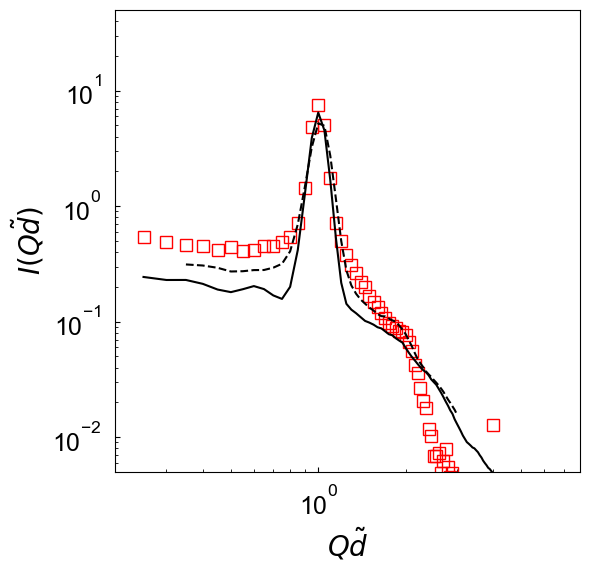

In [10]:
# fitting targets
index_data = 2
IQ_data = IQ_list[index_data,1:-1]
index_qq_fit = (qq[1:-1]/np.pi/20>0.3)*(qq[1:-1]/np.pi/20<3)

IQ_data = IQ_data
qq_data = qq[1:-1]

# create parameters for fitting
x0 =  [1.0, 1,  0.4, 1e5, 1.05]
lb =  [0.2, 0.1,  0.1, 5e4, 0.9]
ub =  [2.0, 10, 0.6, 1e6, 1.1]
fp_names = ['sigma_k', 'kappa', 'alpha', 'y_scale', 'x_scale']

params = Parameters()
for i_names in range(5):
    params.add(fp_names[i_names], value=x0[i_names], min=lb[i_names], max=ub[i_names])
    
index_Q = index_qq_fit

# do fit, here with the default leastsq algorithm
minner = Minimizer(lmbda, params, fcn_args=(qq_data, IQ_data, index_Q))
result = minner.minimize('ampgo')

# write error report
report_fit(result)

## plot fitting results
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

index_plot = qq_data>15
ax.plot(qq_data[index_plot]/np.pi/20,IQ_data[index_plot],'sr',fillstyle='none',ms=8)
ax.plot(qq_data[index_qq_fit]/np.pi/20,IQ_th(qq_data,params)[index_qq_fit],'k--')
ax.plot(qq_data[index_plot]/np.pi/20,IQ_th(qq_data,result.params)[index_plot],'k-')

ax.set_xlabel(r'$Q\tilde{d}$',fontsize=20)
ax.set_ylabel(r'$I(Q\tilde{d})$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.2,8])
ax.set_ylim([0.005,50])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

## Fit using D. Roux's model

In [11]:
def alpha(Cp, n):
    Euler = 0.577215664901533
    alpha = Cp/4.0/np.pi**2*(np.log(np.pi*n) + Euler)
    return(alpha)

def lamellar_stack_caille(Q, d_spacing, thickness, Caille_parameter, scale, background, deltaq=0.01, Nlayers=20):
    P = (1-np.cos(Q*thickness))/Q**2
    S = np.zeros_like(Q)
    for n in (np.arange(Nlayers-1)+1):
        a = alpha(Caille_parameter, n)
        t1 = 1+2*deltaq**2*d_spacing**2*a
        t2 = 2.0*Q**2*d_spacing**2*a
        t3 = -(t2+deltaq**2*d_spacing**2*n**2)/2.0/t1
        t4 = 1/np.sqrt(t1)
        temp_S = (1-n/Nlayers)*np.cos(n*Q*d_spacing/t1)*np.exp(t3)*t4
        S+=2*temp_S

    S = S+1
    
    I = scale*P*S + background
    return I

def lamellar_stack_paracrystal(Q, d_spacing, thickness, Delta, scale, background, deltaq=0.01, Nlayers=20):
    P = (1-np.cos(Q*thickness))/Q**2
    S = np.zeros_like(Q)
    for n in (np.arange(Nlayers-1)+1):
        temp_S = (1-n/Nlayers)*np.cos(n*Q*d_spacing)*np.exp(-n**2*Q**2*Delta**2)
        S+=2*temp_S

    S = S+1
    
    I = scale*P*S + background
    return I

In [12]:
def IQ_th_Roux(Q, params):
    v = params.valuesdict()
    IQ = lamellar_stack_caille(Q*v['d_spacing']*2*np.pi, 1, v['thickness'], v['Caille_parameter'], v['scale'], 
                               background=0, deltaq=0.1, Nlayers=100)
    return IQ

def lmbda_Roux(params, Q, data, index_Q):
    IQ_model = IQ_th_Roux(Q, params)
    residue = ((data*Q**4) - (IQ_model*Q**4))[index_Q]
    return residue

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 97
    # data points      = 60
    # variables        = 4
    chi-square         = 954.392230
    reduced chi-square = 17.0427184
    Akaike info crit   = 174.003810
    Bayesian info crit = 182.381188
[[Variables]]
    d_spacing:         0.98360856 +/- 0.00376996 (0.38%) (init = 1)
    thickness:         0.30165182 +/- 0.00558647 (1.85%) (init = 0.1)
    Caille_parameter:  0.29366369 +/- 0.02968147 (10.11%) (init = 0.2)
    scale:             97.0379561 +/- 6.05016422 (6.23%) (init = 100)
[[Correlations]] (unreported correlations are < 0.100)
    C(thickness, scale)            = +0.6334
    C(Caille_parameter, scale)     = +0.3783
    C(d_spacing, thickness)        = -0.3448
    C(thickness, Caille_parameter) = +0.2230


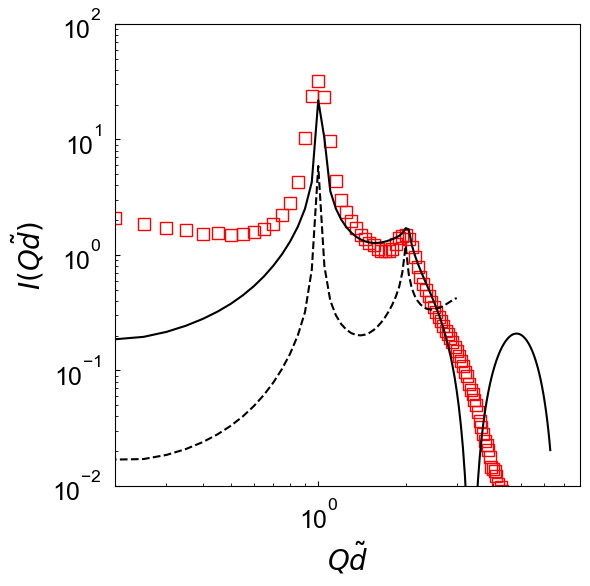

In [13]:
# fitting targets
index_data = 0
IQ_data = IQ_list[index_data,1:-1]

IQ_data = IQ_data
qq_data = qq[1:-1]/np.pi/20
index_qq_fit = (qq_data>0.01)*(qq_data<3)

# create parameters for fitting
x0 =  [1.0, 0.1, 0.2,   100]
lb =  [0.5, 0.01, 0.001, 1]
ub =  [2.0,  1.00, 0.5,   1000]
fp_names = ['d_spacing', 'thickness', 'Caille_parameter', 'scale']

params = Parameters()
for i_names in range(4):
    params.add(fp_names[i_names], value=x0[i_names], min=lb[i_names], max=ub[i_names])
    
index_Q = index_qq_fit

# do fit, here with the default leastsq algorithm
minner = Minimizer(lmbda_Roux, params, fcn_args=(qq_data, IQ_data, index_Q))
result = minner.minimize('leastsq')

# write error report
report_fit(result)

## plot fitting results
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

index_plot = qq_data>0
ax.plot(qq_data[index_plot],IQ_data[index_plot],'sr',fillstyle='none',ms=8)
ax.plot(qq_data[index_qq_fit],IQ_th_Roux(qq_data,params)[index_qq_fit],'k--')
ax.plot(qq_data[index_plot],IQ_th_Roux(qq_data,result.params)[index_plot],'k-')

ax.set_xlabel(r'$Q\tilde{d}$',fontsize=20)
ax.set_ylabel(r'$I(Q\tilde{d})$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.2,8])
ax.set_ylim([0.01,100])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
